#### Resumen del Problema

La fiebre del dengue es una enfermedad transmitida por mosquitos en áreas tropicales y subtropicales. Los síntomas incluyen fiebre, erupción cutánea y dolor muscular en casos leves, pero en casos graves puede causar hemorragias y hasta la muerte. Los factores climáticos, como la temperatura y la precipitación, afectan la transmisión del dengue, y el cambio climático podría aumentar su propagación. La enfermedad solía ser más común en el sudeste asiático y las islas del Pacífico, pero en la actualidad, la mayoría de los casos ocurren en América Latina, con casi 500 millones de casos al año.

Por lo tanto, lo que vamos a hacer a continuación es mediante una información facilitada vamos a intentar predecir la cantidad de casos. Esta información solo la tenemos de dos ciudades del mundo. 

####Importaciones de lo necesario en el proyecto

In [ ]:
# Importaciones necesarias
import pandas as pd
import io
from google.colab import files
import matplotlib.pyplot as plt
import numpy as np
import itertools
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import classification_report
from numpy.core import numeric
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MaxAbsScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_error


#### Descargamos los 3 ficheros dos de train y un test 

In [ ]:
# Importamos los dos ficheros el train y el test
url1 = 'https://raw.githubusercontent.com/Ruben11040/Proyectos_Colab/main/DengAI%3A%20Predicting%20Disease%20Spread/dengue_features_test.csv'
dftest = pd.read_csv(url1)
url2 = 'https://raw.githubusercontent.com/Ruben11040/Proyectos_Colab/main/DengAI%3A%20Predicting%20Disease%20Spread/dengue_features_train.csv'
dftrain = pd.read_csv(url2)
url3 = 'https://raw.githubusercontent.com/Ruben11040/Proyectos_Colab/main/DengAI%3A%20Predicting%20Disease%20Spread/dengue_labels_train.csv'
dftrain_y = pd.read_csv(url3)

In [ ]:
#Rellenamos los valores que se encuentran nulos con 0
dftrain.fillna(0, inplace = True)
dftest.fillna(0, inplace = True)

Ver las Columanas que componen el dataframe

In [ ]:
dftrain.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1456 entries, 0 to 1455
Data columns (total 24 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   city                                   1456 non-null   object 
 1   year                                   1456 non-null   int64  
 2   weekofyear                             1456 non-null   int64  
 3   week_start_date                        1456 non-null   object 
 4   ndvi_ne                                1456 non-null   float64
 5   ndvi_nw                                1456 non-null   float64
 6   ndvi_se                                1456 non-null   float64
 7   ndvi_sw                                1456 non-null   float64
 8   precipitation_amt_mm                   1456 non-null   float64
 9   reanalysis_air_temp_k                  1456 non-null   float64
 10  reanalysis_avg_temp_k                  1456 non-null   float64
 11  rean

#### Matríz de Correlación

Antes de hacer la Matriz de correlación lo que vamos a hacer es pasar todos los datos categóricos a numéricos, pero como en el anterior apartado hemos eliminado todos los valores que no sean numéricos, no tendríamos problemas.

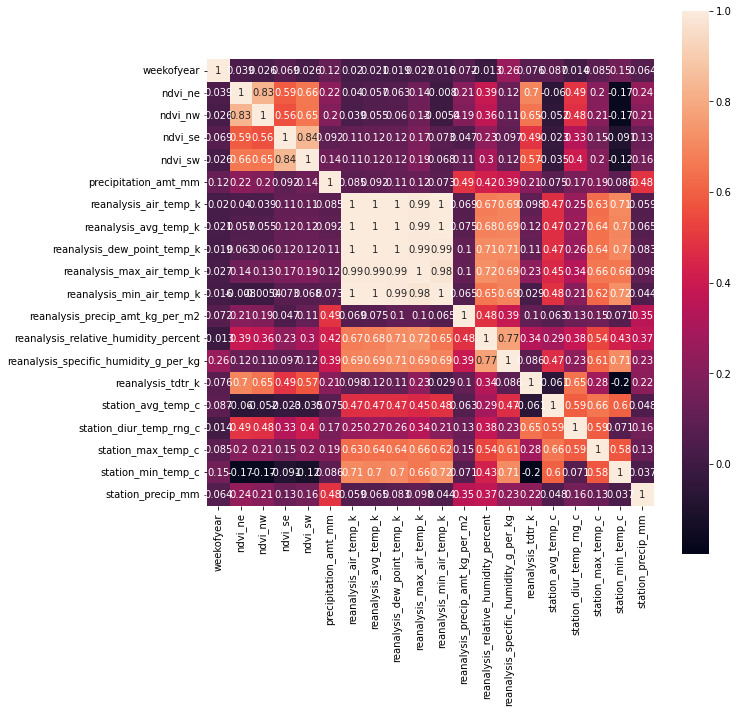

In [ ]:
fig, ax = plt.subplots(figsize=(20,20))
sns.heatmap(dftrain.corr(), annot=True, square=True)
plt.show()

A continuación, lo que vamos a hacer es quitar o sustituir los valores que yo considere oportunos para poder empezar con el estudio de los datos. Tras varias pruebas con distintas conjuntos de datos y una exaustiva busqueda para conseguir el mejor resultado he llegado a la conclusión de que unicamente omitiendo los valores de 'city', 'week_start_date' y 'year'. Y quitamos también 'reanalysis_sat_precip_amt_mm' debido a que en la matriz anterior muestra una relación de 1 con otro valor.

In [ ]:
dftrain.drop(['city'], axis = 1, inplace=True)
dftrain.drop(['week_start_date'], axis = 1, inplace=True)
dftrain.drop(['year'], axis = 1, inplace=True)
dftrain.drop(['reanalysis_sat_precip_amt_mm'], axis = 1, inplace=True)

dftest.drop(['city'], axis = 1, inplace=True)
dftest.drop(['week_start_date'], axis = 1, inplace=True)
dftest.drop(['year'], axis = 1, inplace=True)
dftest.drop(['reanalysis_sat_precip_amt_mm'], axis = 1, inplace=True)

Volvemos a mostrar la matriz de correlación pero con los valores anteriores eliminados. 

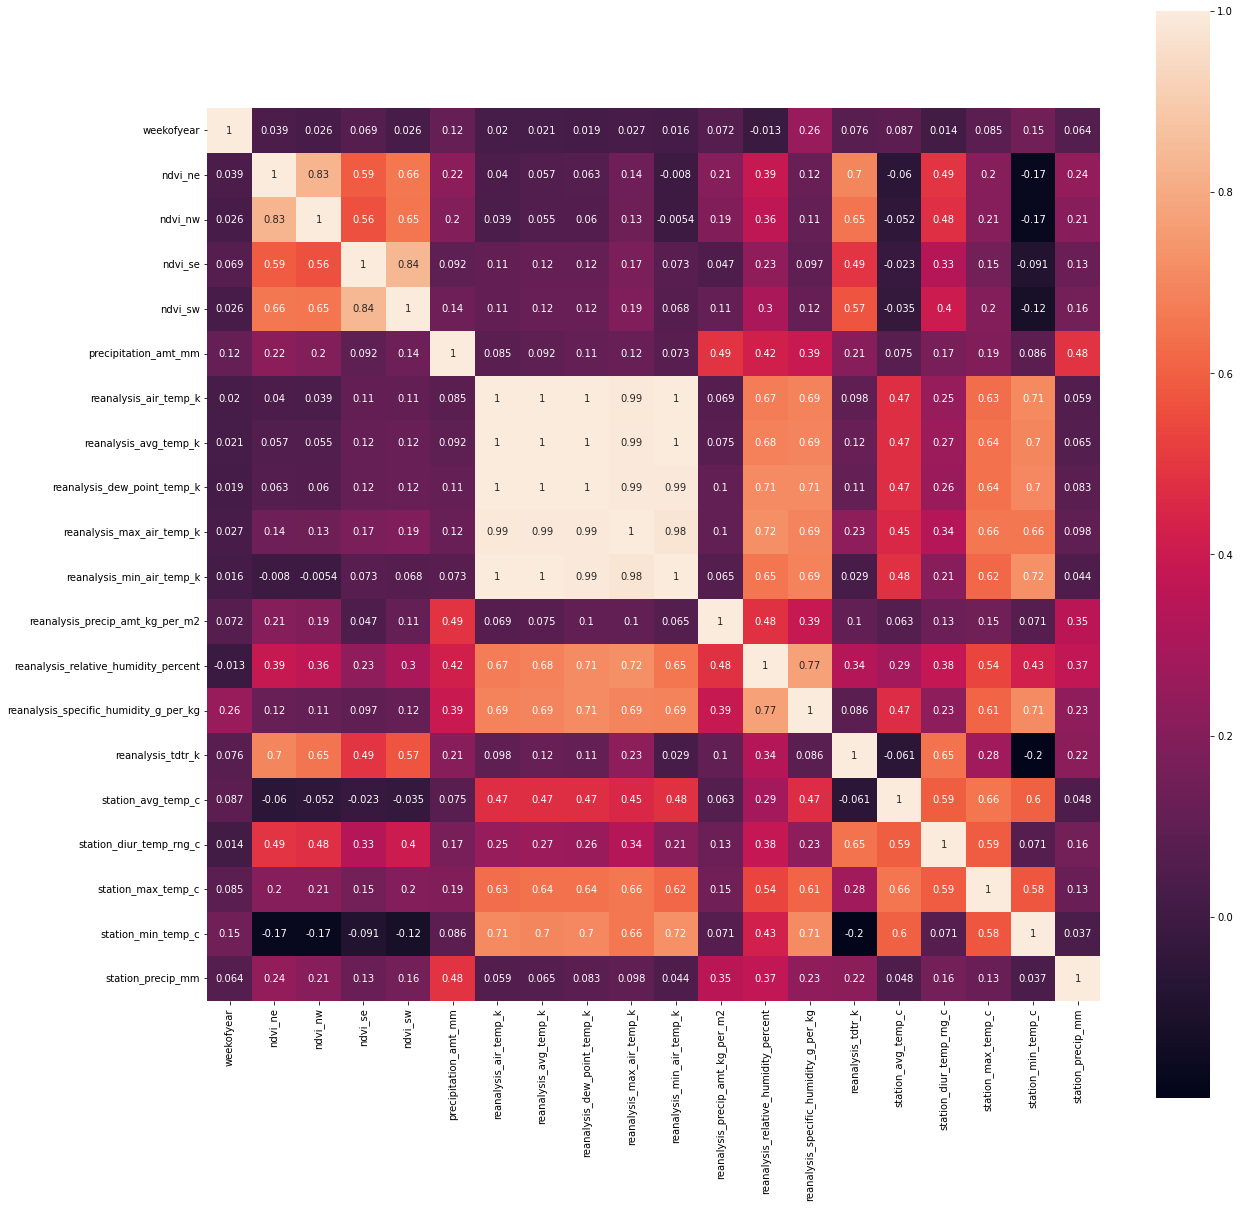

In [ ]:
fig, ax = plt.subplots(figsize=(20,20))
sns.heatmap(dftrain.corr(), annot=True, square=True)
plt.show()

In [ ]:
# Como puedes observar en uno de los intentos paso las ciudades que son valores categóricos a numéricos

# dftrain['city'] = dftrain['city'].replace({'sj': 0, 'iq': 1})
# dftest['city'] = dftest['city'].replace({'sj': 0, 'iq': 1})

#Lo que hacemos es escalar tanto el xtrain y el xtest, pero no las y, ya que, si no la escalamos no haría falta desescalarlo o escalar el predict 
scaler = MaxAbsScaler()
dftrain[dftrain.columns] = scaler.fit_transform(dftrain)
dftest[dftest.columns] = scaler.fit_transform(dftest)

In [ ]:
# separamos datos de entrada y salida
# en un ejemplo anterior solo obtenía los datos del data train desde el 2008 hasta el 2010
# dftrain = dftrain.loc[(dftrain['year'] >= 2008)  &  (dftrain['year'] <= 2010)]
X = dftrain
y = dftrain_y['total_cases']

# separamos train y test usando unicamente el dataframe de train descargado anteriormente. 
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=5)

# Modelo KNN de Regression

Creamos el modelo de KNN Regression sin Cross Validation y a continuación, veremos los dos mejos valores de weigths y de n_neighbros.

Min Value uniform : 15.725400457665904 (3)
Min Value distance : 15.724432340723508 (8)


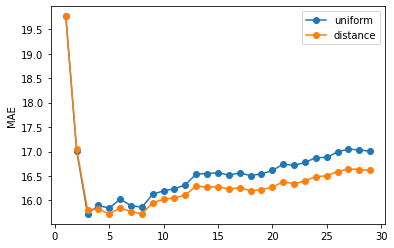

In [ ]:
for i, weights in enumerate(['uniform', 'distance']):
   total_scores = []
   for n_neighbors in range(1,30):
      fold_accuracy = []
      knn = KNeighborsRegressor(n_neighbors, weights=weights)
      # entrenamiento y ejecución del modelo
      knn.fit(x_train,y_train)
      y_pred = knn.predict(x_test)
      # evaluación del modelo
      mae = mean_absolute_error(y_test, y_pred)
      fold_accuracy.append(mae)
      total_scores.append(sum(fold_accuracy)/len(fold_accuracy))
   plt.plot(range(1,len(total_scores)+1), total_scores, 
             marker='o', label=weights)
   print ('Min Value ' +  weights + " : " +  str(min(total_scores)) +" (" + str(np.argmin(total_scores) + 1) + ")")
   plt.ylabel('MAE')    
plt.legend()
plt.show()

### Matriz de Dispersión

Text(0, 0.5, 'Predicted total_cases')

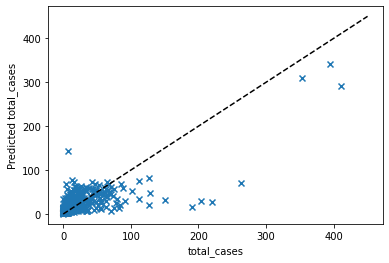

In [ ]:
knn = KNeighborsRegressor(n_neighbors= (np.argmin(total_scores) + 1), weights= weights)
knn.fit(x_train,y_train)
y_pred = knn.predict(x_test)

plt.scatter(y_test, y_pred , marker = 'x')
plt.plot([0, 450], [0, 450], "--k")
plt.axis("tight")
plt.xlabel("total_cases")
plt.ylabel("Predicted total_cases")

# Interpretación de la gráfica:
# En la diagonal están los valores de test, y los puntos dispersos son las predicción. De esta forma podemos ver lo cerca/lejos que están los resultados
# predichos de los de entrenamiento
# Cuanto más cerca están las X de la recta mejor será la predicción.

# Descargar el modelo predicho

Lo que estoy haciendo a continuación es predecir con el dftest que son los de xtest y luego pasamos de float a int. Para finalizar descargamos el csv donde tenemos que poner los valores recogidos y descargamos.

In [ ]:
y_pred = knn.predict(dftest)
y_pred = y_pred.astype(int)

In [ ]:
url4 = 'https://raw.githubusercontent.com/Ruben11040/Proyectos_Colab/main/DengAI%3A%20Predicting%20Disease%20Spread/submission_format.csv'
dfsubmission = pd.read_csv(url4)
dfsubmission['total_cases'] = y_pred

In [ ]:
dfsubmission.to_csv('resultado-v1_2.csv', index=False)